In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from yahoo_historical import Fetcher


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
ticker = 'AAPL'
dstart = [2019,1,1]


dataset = Fetcher(ticker, dstart).getHistorical()	
#df = df[['Date','Close']]
dataset.Date = pd.to_datetime(dataset.Date)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,38.562561,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.721451,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,36.203678,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,36.123104,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.811718,164101200


In [4]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
524,2021-02-01,133.750000,135.380005,130.929993,134.139999,134.139999,106239800
525,2021-02-02,135.729996,136.309998,134.610001,134.990005,134.990005,83305400
526,2021-02-03,135.759995,135.770004,133.610001,133.940002,133.940002,89880900
527,2021-02-04,136.300003,137.399994,134.589996,137.389999,137.389999,84183100
528,2021-02-05,137.350006,137.410004,135.860001,136.759995,136.759995,72317009


In [5]:
dataset.shape

(529, 7)

In [6]:
dataset.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [7]:
timestamp = dataset.Date

In [8]:
target = dataset.Close

In [9]:
#remove Time and Name as they are not useful for LSTM
#move Clsoe to last column to make data splitting easier
dataset.drop(['Date','Close','Adj Close'], axis=1, inplace=True)
dataset['Close'] = target

In [10]:
dataset.head()

,Open,High,Low,Volume,Close
0,38.722500,39.712502,38.557499,148158800,39.480000
1,35.994999,36.430000,35.500000,365248800,35.547501
2,36.132500,37.137501,35.950001,234428400,37.064999
3,37.174999,37.207500,36.474998,219111200,36.982498
4,37.389999,37.955002,37.130001,164101200,37.687500


In [11]:
dataset.shape

(529, 5)

In [12]:
values = dataset.values

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [14]:
scaled

array([[0.02534734, 0.03020893, 0.02887975, 0.26927344, 0.03654314],
       [0.        , 0.        , 0.        , 0.83841098, 0.        ],
       [0.00127783, 0.00651115, 0.00425051, 0.49544354, 0.0141015 ],
       ...,
       [0.92714083, 0.91422794, 0.92670261, 0.11648824, 0.9143222 ],
       [0.93215926, 0.92922877, 0.9359592 , 0.10155051, 0.94638165],
       [0.9419172 , 0.92932089, 0.94795509, 0.07044158, 0.94052727]])

In [15]:
# specify the number of lag hours
n_hours = 3
n_features = 5

In [16]:
# frame as supervised learning
reframed0 = series_to_supervised(values, n_hours, 1)
print(reframed0.shape)

(526, 20)


In [17]:
reframed0.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,38.722500,39.712502,38.557499,148158800.0,39.480000,35.994999,36.430000,35.500000,365248800.0,35.547501,36.132500,37.137501,35.950001,234428400.0,37.064999,37.174999,37.207500,36.474998,219111200.0,36.982498
4,35.994999,36.430000,35.500000,365248800.0,35.547501,36.132500,37.137501,35.950001,234428400.0,37.064999,37.174999,37.207500,36.474998,219111200.0,36.982498,37.389999,37.955002,37.130001,164101200.0,37.687500
5,36.132500,37.137501,35.950001,234428400.0,37.064999,37.174999,37.207500,36.474998,219111200.0,36.982498,37.389999,37.955002,37.130001,164101200.0,37.687500,37.822498,38.632500,37.407501,180396400.0,38.327499
6,37.174999,37.207500,36.474998,219111200.0,36.982498,37.389999,37.955002,37.130001,164101200.0,37.687500,37.822498,38.632500,37.407501,180396400.0,38.327499,38.125000,38.492500,37.715000,143122800.0,38.450001
7,37.389999,37.955002,37.130001,164101200.0,37.687500,37.822498,38.632500,37.407501,180396400.0,38.327499,38.125000,38.492500,37.715000,143122800.0,38.450001,38.220001,38.424999,37.877499,108092800.0,38.072498


In [18]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(526, 20)


In [19]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.025347,0.030209,0.028880,0.269273,0.036543,0.000000,0.000000,0.000000,0.838411,0.000000,0.001278,0.006511,0.004251,0.495444,0.014102,0.010966,0.007155,0.009209,0.455287,0.013335
4,0.000000,0.000000,0.000000,0.838411,0.000000,0.001278,0.006511,0.004251,0.495444,0.014102,0.010966,0.007155,0.009209,0.455287,0.013335,0.012964,0.014035,0.015396,0.311069,0.019886
5,0.001278,0.006511,0.004251,0.495444,0.014102,0.010966,0.007155,0.009209,0.455287,0.013335,0.012964,0.014035,0.015396,0.311069,0.019886,0.016983,0.020270,0.018017,0.353790,0.025833
6,0.010966,0.007155,0.009209,0.455287,0.013335,0.012964,0.014035,0.015396,0.311069,0.019886,0.016983,0.020270,0.018017,0.353790,0.025833,0.019795,0.018981,0.020922,0.256071,0.026972
7,0.012964,0.014035,0.015396,0.311069,0.019886,0.016983,0.020270,0.018017,0.353790,0.025833,0.019795,0.018981,0.020922,0.256071,0.026972,0.020677,0.018360,0.022457,0.164234,0.023464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,0.998420,0.992730,0.990932,0.250096,0.989778,0.962084,0.971471,0.955889,0.254755,0.943594,0.927791,0.923155,0.894588,0.345359,0.895923,0.908461,0.910639,0.901388,0.159376,0.916181
525,0.962084,0.971471,0.955889,0.254755,0.943594,0.927791,0.923155,0.894588,0.345359,0.895923,0.908461,0.910639,0.901388,0.159376,0.916181,0.926862,0.919198,0.936148,0.099249,0.924079
526,0.927791,0.923155,0.894588,0.345359,0.895923,0.908461,0.910639,0.901388,0.159376,0.916181,0.926862,0.919198,0.936148,0.099249,0.924079,0.927141,0.914228,0.926703,0.116488,0.914322
527,0.908461,0.910639,0.901388,0.159376,0.916181,0.926862,0.919198,0.936148,0.099249,0.924079,0.927141,0.914228,0.926703,0.116488,0.914322,0.932159,0.929229,0.935959,0.101551,0.946382


In [20]:
reframed.shape

(526, 20)

In [21]:
#pd.DataFrame(scaled).head(10)

In [116]:
# split into train and test sets
values = reframed.values
train = values[:400, :]
val = values[400:450, :]
test = values[450:,:]

In [117]:
arr=[1,2,3,4]
print(arr[0:2])
print(arr[2:4])

[1, 2]
[3, 4]


In [118]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
val_X, val_y = val[:, :n_obs], val[:,-1]
test_X, test_y = test[:, :n_obs], test[:, -1]

In [119]:
print(train_X.shape, train_y.shape, val_X.shape, test_X.shape)

(400, 15) (400,) (50, 15) (76, 15)


In [120]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)


(400, 3, 5) (400,) (50, 3, 5) (50,) (76, 3, 5) (76,)


Epoch 1/50
6/6 - 1s - loss: 0.2257 - val_loss: 0.6655
Epoch 2/50
6/6 - 0s - loss: 0.1525 - val_loss: 0.5194
Epoch 3/50
6/6 - 0s - loss: 0.0870 - val_loss: 0.3469
Epoch 4/50
6/6 - 0s - loss: 0.0843 - val_loss: 0.2182
Epoch 5/50
6/6 - 0s - loss: 0.0988 - val_loss: 0.1857
Epoch 6/50
6/6 - 0s - loss: 0.0901 - val_loss: 0.2076
Epoch 7/50
6/6 - 0s - loss: 0.0760 - val_loss: 0.1882
Epoch 8/50
6/6 - 0s - loss: 0.0618 - val_loss: 0.1154
Epoch 9/50
6/6 - 0s - loss: 0.0498 - val_loss: 0.0401
Epoch 10/50
6/6 - 0s - loss: 0.0444 - val_loss: 0.0449
Epoch 11/50
6/6 - 0s - loss: 0.0360 - val_loss: 0.0754
Epoch 12/50
6/6 - 0s - loss: 0.0280 - val_loss: 0.1290
Epoch 13/50
6/6 - 0s - loss: 0.0321 - val_loss: 0.1240
Epoch 14/50
6/6 - 0s - loss: 0.0298 - val_loss: 0.0763
Epoch 15/50
6/6 - 0s - loss: 0.0267 - val_loss: 0.0578
Epoch 16/50
6/6 - 0s - loss: 0.0287 - val_loss: 0.0793
Epoch 17/50
6/6 - 0s - loss: 0.0303 - val_loss: 0.0529
Epoch 18/50
6/6 - 0s - loss: 0.0315 - val_loss: 0.0498
Epoch 19/50
6/6 - 0

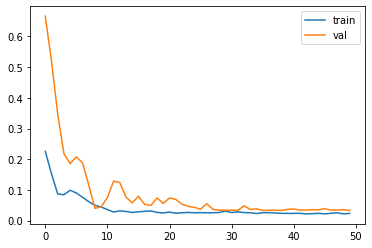

In [121]:
# design network
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [122]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_X.shape

(76, 15)

In [123]:
reframed.iloc[:, -n_features:-1].columns

Index(['var1(t)', 'var2(t)', 'var3(t)', 'var4(t)'], dtype='object')

In [124]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -n_features:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [125]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -n_features:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
import numpy as np
mape = np.mean(100*abs(inv_y-inv_yhat)/inv_y)
smape = np.mean(200*abs(inv_y-inv_yhat)/(inv_y+inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 3.999
Test MAPE: 2.437


In [126]:
inv_y

array([115.980003, 117.510002, 116.870003, 115.75    , 115.040001,
       115.050003, 116.599998, 111.199997, 115.32    , 108.860001,
       108.769997, 110.440002, 114.949997, 119.029999, 118.690002,
       116.32    , 115.970001, 119.489998, 119.209999, 119.260002,
       120.300003, 119.389999, 118.029999, 118.639999, 117.339996,
       113.849998, 115.169998, 116.029999, 116.589996, 119.050003,
       122.720001, 123.080002, 122.940002, 122.25    , 123.75    ,
       124.379997, 121.779999, 123.239998, 122.410004, 121.779999,
       127.879997, 127.809998, 128.699997, 126.660004, 128.229996,
       131.880005, 130.960007, 131.970001, 136.690002, 134.869995,
       133.720001, 132.690002, 129.410004, 131.009995, 126.599998,
       130.919998, 132.050003, 128.979996, 128.800003, 130.889999,
       128.910004, 127.139999, 127.830002, 132.029999, 136.869995,
       139.070007, 142.919998, 143.160004, 142.059998, 137.089996,
       131.960007, 134.139999, 134.990005, 133.940002, 137.389

In [127]:
inv_yhat

array([120.8903396 , 119.91996018, 119.57125192, 118.09692124,
       117.36313619, 117.05919267, 116.39764439, 115.73895044,
       115.41834281, 115.58904405, 114.15821451, 113.27968651,
       110.68073402, 110.75123255, 113.05259799, 116.55583152,
       118.78527448, 118.63904344, 118.40844635, 117.40207041,
       118.86958921, 119.43659852, 119.29272148, 119.43646382,
       119.06618459, 118.34967299, 117.90259007, 117.27992471,
       115.82584367, 115.3806337 , 116.59836411, 118.12394429,
       120.21827844, 122.00815593, 122.27918817, 122.53347932,
       122.45681033, 123.19391794, 123.42196859, 122.59413846,
       121.7380281 , 122.41912046, 123.85533152, 126.37145738,
       127.39408691, 127.84224742, 127.60605073, 128.07931644,
       130.75386674, 130.66066834, 131.95413127, 134.09264647,
       134.03901088, 132.50580422, 131.20980768, 129.67294491,
       128.64185504, 128.30411508, 129.33905989, 129.66111712,
       128.14789712, 128.10666019, 128.7159776 , 128.34

In [128]:
inv_yhat.shape

(76,)

In [129]:
dataset['Date'] = timestamp
dataset.head()

,Open,High,Low,Volume,Close,Date
0,38.722500,39.712502,38.557499,148158800,39.480000,2019-01-02
1,35.994999,36.430000,35.500000,365248800,35.547501,2019-01-03
2,36.132500,37.137501,35.950001,234428400,37.064999,2019-01-04
3,37.174999,37.207500,36.474998,219111200,36.982498,2019-01-07
4,37.389999,37.955002,37.130001,164101200,37.687500,2019-01-08


In [130]:
tr = dataset.iloc[:450,:]
te = dataset.iloc[450:,]

In [131]:
print(tr.shape)
print(te.shape)

(450, 6)
(79, 6)


In [132]:
te.Date[4:].head()

454   2020-10-20
455   2020-10-21
456   2020-10-22
457   2020-10-23
458   2020-10-26
Name: Date, dtype: datetime64[ns]

In [133]:
te.Date.head()

450   2020-10-14
451   2020-10-15
452   2020-10-16
453   2020-10-19
454   2020-10-20
Name: Date, dtype: datetime64[ns]

In [134]:
te.Date.tail()

524   2021-02-01
525   2021-02-02
526   2021-02-03
527   2021-02-04
528   2021-02-05
Name: Date, dtype: datetime64[ns]

In [135]:
from pandas.tseries.offsets import BDay
dates = te.Date[4:]
dates = dates.append(te.Date.tail(1) + BDay(1))
dates.tail()

525   2021-02-02
526   2021-02-03
527   2021-02-04
528   2021-02-05
528   2021-02-08
Name: Date, dtype: datetime64[ns]

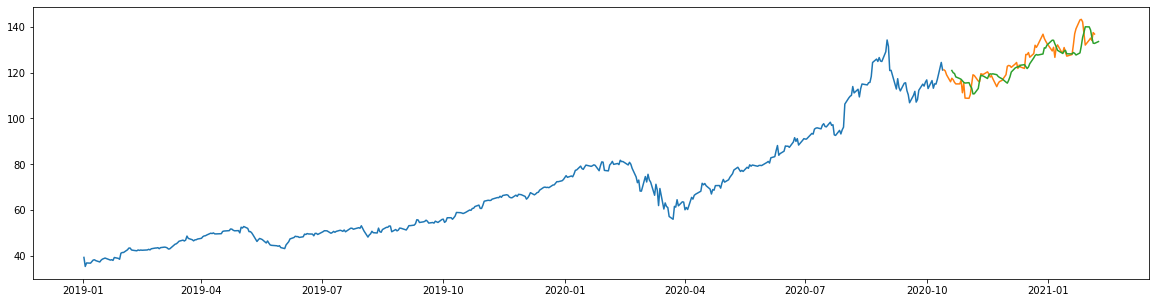

In [136]:
plt.figure(figsize=(20,5))
plt.plot(tr.Date, tr.Close)
plt.plot(te.Date, te.Close)
plt.plot(dates, inv_yhat)

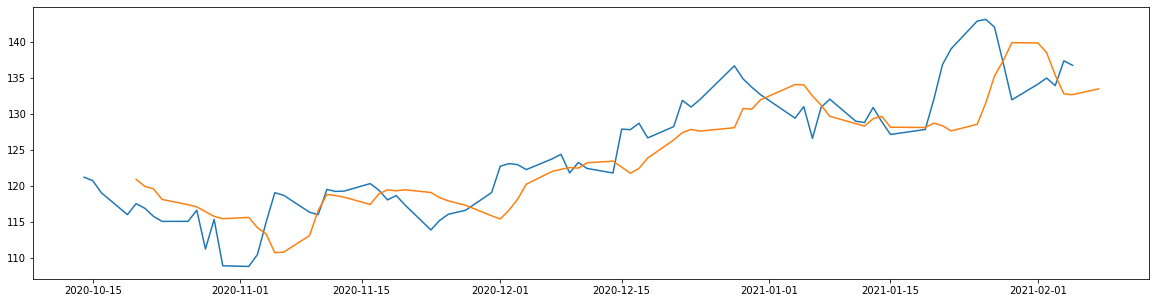

In [137]:
plt.figure(figsize=(20,5))
plt.plot(te.Date, te.Close)
plt.plot(dates, inv_yhat)

In [138]:
df_pred = pd.DataFrame(dates, columns = ['Date']).reset_index(drop=True)
df_pred['pred'] = inv_yhat
df_pred.head()

,Date,pred
0,2020-10-20,120.890340
1,2020-10-21,119.919960
2,2020-10-22,119.571252
3,2020-10-23,118.096921
4,2020-10-26,117.363136


In [139]:
merged_data = te.merge(df_pred, on = 'Date')

In [140]:
merged_data

,Open,High,Low,Volume,Close,Date,pred
0,116.199997,118.980003,115.629997,124423700,117.510002,2020-10-20,120.890340
1,116.669998,118.709999,116.449997,89946000,116.870003,2020-10-21,119.919960
2,117.449997,118.040001,114.589996,101988000,115.750000,2020-10-22,119.571252
3,116.389999,116.550003,114.279999,82572600,115.040001,2020-10-23,118.096921
4,114.010002,116.550003,112.879997,111850700,115.050003,2020-10-26,117.363136
...,...,...,...,...,...,...,...
70,133.750000,135.380005,130.929993,106239800,134.139999,2021-02-01,139.877823
71,135.729996,136.309998,134.610001,83305400,134.990005,2021-02-02,138.540506
72,135.759995,135.770004,133.610001,89880900,133.940002,2021-02-03,135.391831
73,136.300003,137.399994,134.589996,84183100,137.389999,2021-02-04,132.783963


In [141]:
merged_data['dir'] = merged_data.Close-merged_data.Close.shift(1)
merged_data.head()

,Open,High,Low,Volume,Close,Date,pred,dir
0,116.199997,118.980003,115.629997,124423700,117.510002,2020-10-20,120.890340,NaN
1,116.669998,118.709999,116.449997,89946000,116.870003,2020-10-21,119.919960,-0.639999
2,117.449997,118.040001,114.589996,101988000,115.750000,2020-10-22,119.571252,-1.120003
3,116.389999,116.550003,114.279999,82572600,115.040001,2020-10-23,118.096921,-0.709999
4,114.010002,116.550003,112.879997,111850700,115.050003,2020-10-26,117.363136,0.010002


In [142]:
merged_data['dir'] = merged_data['dir']>0
merged_data['dir'] =  merged_data['dir'].astype(int)
merged_data.head()

,Open,High,Low,Volume,Close,Date,pred,dir
0,116.199997,118.980003,115.629997,124423700,117.510002,2020-10-20,120.890340,0
1,116.669998,118.709999,116.449997,89946000,116.870003,2020-10-21,119.919960,0
2,117.449997,118.040001,114.589996,101988000,115.750000,2020-10-22,119.571252,0
3,116.389999,116.550003,114.279999,82572600,115.040001,2020-10-23,118.096921,0
4,114.010002,116.550003,112.879997,111850700,115.050003,2020-10-26,117.363136,1


In [143]:
merged_data['dir_pred'] = merged_data.pred-merged_data.pred.shift(1)
merged_data['dir_pred'] = merged_data['dir_pred']>0
merged_data['dir_pred'] =  merged_data['dir_pred'].astype(int)
merged_data.head(20)

,Open,High,Low,Volume,Close,Date,pred,dir,dir_pred
0,116.199997,118.980003,115.629997,124423700,117.510002,2020-10-20,120.890340,0,0
1,116.669998,118.709999,116.449997,89946000,116.870003,2020-10-21,119.919960,0,0
2,117.449997,118.040001,114.589996,101988000,115.750000,2020-10-22,119.571252,0,0
3,116.389999,116.550003,114.279999,82572600,115.040001,2020-10-23,118.096921,0,0
4,114.010002,116.550003,112.879997,111850700,115.050003,2020-10-26,117.363136,1,0
5,115.489998,117.279999,114.540001,92276800,116.599998,2020-10-27,117.059193,1,0
6,115.050003,115.430000,111.099998,143937800,111.199997,2020-10-28,116.397644,0,0
7,112.370003,116.930000,112.199997,146129200,115.320000,2020-10-29,115.738950,1,0
8,111.059998,111.989998,107.720001,190272600,108.860001,2020-10-30,115.418343,0,0
9,109.110001,110.680000,107.320000,122866900,108.769997,2020-11-02,115.589044,0,1


In [147]:
match = merged_data.dir==merged_data.dir_pred
match.sum()/len(match)

0.37333333333333335